---

# APIs and web scraping in Python

Connecting to a remote web API in Python is easy with the `requests` library (https://requests.readthedocs.io/en/latest/).

In [1]:
import requests

To *get* data from an API, we make an HTTP GET request.

All we need is the url.

We will use the Star Wars API at https://swapi.dev.
    
Their "root" API returns all the possible API endpoints and their urls, let's start there.

In [2]:
url = "https://swapi.dev/api"

response = requests.get(url)

In [3]:
type(response)

requests.models.Response

Every HTTP response comes with a *status code* which tells us whether the request was successful.

- 200 means everything was fine
- values in the 300 range mean some sort of redirection happened
- the 400 range means client error - the requester did something wrong like type an incorrect url (404 means "not found" for example)
- the 500 range means server error - the request was fine but the web server encountered a problem in trying to respond

If you ever want to know what a status code means, you can use the website http.cat, e.g. https://http.cat/404

In [4]:
response.status_code

200

There is also a convenience method to check if the response errored. This does nothing if the request was fine, otherwise it will raise an exception.

In [5]:
response.raise_for_status()

The response object contains the response as raw text

In [6]:
response.text

'{"people":"https://swapi.dev/api/people/","planets":"https://swapi.dev/api/planets/","films":"https://swapi.dev/api/films/","species":"https://swapi.dev/api/species/","vehicles":"https://swapi.dev/api/vehicles/","starships":"https://swapi.dev/api/starships/"}'

But if the data is sent back in JSON format we can convert the response to a Python object

In [7]:
response_json = response.json()

In [8]:
type(response_json)

dict

In [9]:
response_json

{'people': 'https://swapi.dev/api/people/',
 'planets': 'https://swapi.dev/api/planets/',
 'films': 'https://swapi.dev/api/films/',
 'species': 'https://swapi.dev/api/species/',
 'vehicles': 'https://swapi.dev/api/vehicles/',
 'starships': 'https://swapi.dev/api/starships/'}

And now we can access the data inside it like any other Python object!

In [ ]:
response_json["people"]

Let's actually call one of these APIs to gather some data.

In [ ]:
people_url = response_json["people"]

people = requests.get(people_url).json()

In [ ]:
people

In [ ]:
people["results"]

In [ ]:
people["results"][0]

<h1 style="color: #fcd805">Exercise: APIs</h1>

1. Every endpoint in the Star Wars API supports searching. Read the documentation at https://swapi.dev/documentation#search and see if you can search the database to find **Darth Vader's height**.

In [7]:
import requests 
url = "https://swapi.dev/api"

response = requests.get(url)
#type(response)
#response.status_code
response.text


'{"people":"https://swapi.dev/api/people/","planets":"https://swapi.dev/api/planets/","films":"https://swapi.dev/api/films/","species":"https://swapi.dev/api/species/","vehicles":"https://swapi.dev/api/vehicles/","starships":"https://swapi.dev/api/starships/"}'

In [14]:
response_json = response.json()
ppl_url = response_json["people"]
ppl_response = requests.get(ppl_url)
ppl_response_json = ppl_response.json()

In [25]:
#ppl_response_json["results"]
for item in  ppl_response_json["results"]:
    if(item["name"]=="Darth Vader"):
        print(f"{item['name']}'s height is {item['height']}")

Darth Vader's height is 202


2. Find the **endpoint** (i.e. the specific url) responsible for returning data about starships.

Use this endpoint to search the database and find the Millennium Falcon.

What is its **cargo capacity**?

In [26]:
starship_url = response_json["starships"]

starship = requests.get(starship_url).json()

In [38]:
starship
for item in  starship["results"]:
    if(item["name"]=="Millennium Falcon"):
        print(f"{item['name']}'s cargo capacity is {item['cargo_capacity']}")
        for pilots in item["pilots"]:
            #print(pilots)
            pilot_data=requests.get(pilots).json()
            print(pilot_data["name"])
        exit

Millennium Falcon's cargo capacity is 100000
Chewbacca
Han Solo
Lando Calrissian
Nien Nunb


3. Every starship record contains links to its pilots. Find the characters who have piloted the Millennium Falcon and print their names.

*Hint: you may need to make further API calls...!*

In [ ]:
#Done above

## Converting API data to `pandas`

Not only can we convert an API response to a Python object, we can convert it to a `pandas` DataFrame (if we have a list of values).

Let's use the endpoint to give us a collection of people:

In [44]:
people_response = requests.get("https://swapi.dev/api/people")

people_response.raise_for_status()

people = people_response.json()

people

{'count': 82,
 'next': 'https://swapi.dev/api/people/?page=2',
 'previous': None,
 'results': [{'name': 'Luke Skywalker',
   'height': '172',
   'mass': '77',
   'hair_color': 'blond',
   'skin_color': 'fair',
   'eye_color': 'blue',
   'birth_year': '19BBY',
   'gender': 'male',
   'homeworld': 'https://swapi.dev/api/planets/1/',
   'films': ['https://swapi.dev/api/films/1/',
    'https://swapi.dev/api/films/2/',
    'https://swapi.dev/api/films/3/',
    'https://swapi.dev/api/films/6/'],
   'species': [],
   'vehicles': ['https://swapi.dev/api/vehicles/14/',
    'https://swapi.dev/api/vehicles/30/'],
   'starships': ['https://swapi.dev/api/starships/12/',
    'https://swapi.dev/api/starships/22/'],
   'created': '2014-12-09T13:50:51.644000Z',
   'edited': '2014-12-20T21:17:56.891000Z',
   'url': 'https://swapi.dev/api/people/1/'},
  {'name': 'C-3PO',
   'height': '167',
   'mass': '75',
   'hair_color': 'n/a',
   'skin_color': 'gold',
   'eye_color': 'yellow',
   'birth_year': '112BB

`pandas` interprets a list of dictionaries as a collection of rows.

Keys in the dictionaries become columns and the values become the row values:

In [ ]:
import pandas as pd

people_df = pd.DataFrame(people["results"])

people_df.head()

Let's now enhance the data by downloading details of each person's homeworld.

We can do this by calling the url in the `homeworld` column and saving the returned values to another column.

In [ ]:
def fetch_homeworld_data(url):
    try:
        return requests.get(url).json()
    except Exception as e:
        return None  # Return None in case of any errors

# Apply the function to the 'homeworld' column and save the result in 'homeworld_data'
people_df['homeworld_data'] = people_df['homeworld'].apply(fetch_homeworld_data)

people_df.head()

Pretty good! But we ran into a problem because the `homeworld_data` column is a dictionary.

We can "unpack" this in `pandas` into separate columns:

In [ ]:
people_homeworlds = pd.json_normalize(people_df["homeworld_data"])
people_homeworlds.head()

In [ ]:
# we'll rename columns to start with `homeworld_`
people_homeworlds.columns = ["homeworld_" + c for c in people_homeworlds.columns]

people_homeworlds.head()

Now all that remains is to put these two datasets together.

This isn't a join, we actually just want to connect the two `DataFrame`s side by side without a join key.

We can do this with `.concat()`:

In [ ]:
# concat takes a LIST of DataFrames
# axis is either 0 (horizontal, two DataFrames on top of one another)
# or 1 (vertical, two DataFrames side by side)
people_df_final = pd.concat([people_df, people_homeworlds], axis=1)
people_df_final.head()

We can also drop the original `homeworld` column

In [ ]:
people_df_final = people_df_final.drop(columns=["homeworld"])

people_df_final

We need to some data cleaning and type conversion, but otherwise we can analyse this data in `pandas`!

In [ ]:
people_df_final["homeworld_climate"].value_counts()

In [ ]:
import numpy as np

people_df_final["homeworld_orbital_period"] = people_df_final["homeworld_orbital_period"].replace("unknown", np.nan)
people_df_final["homeworld_orbital_period"] = people_df_final["homeworld_orbital_period"].astype(float)

people_df_final["homeworld_orbital_period"].mean()

### API keys

Most APIs require authentication of some sort.

Often this just means signing up for an API key, which is a string that's unique to you. Keep it safe, like a password.

Depending on the API, using a key can be as easy as adding it into the url as an extra parameter.

For example, Alpha Vantage (a free API service for stock price data) requires an email signup to generate a key.

The example urls all have the key of `"demo"` which you simply replace with your own key:

https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol=IBM&interval=5min&apikey=demo

<h1 style="color: #fcd805">Exercise: APIs and `pandas`</h1>

We're going to explore a new API, which exposes data about the Nobel Prize.

The API documentation is here: [https://app.swaggerhub.com/apis/NobelMedia/NobelMasterData/2.0](https://app.swaggerhub.com/apis/NobelMedia/NobelMasterData/2.0)

(the developer Hub is here: [https://www.nobelprize.org/organization/developer-zone-2](https://www.nobelprize.org/organization/developer-zone-2))

The url to retrieve information about prizes is [https://api.nobelprize.org/2.1/nobelPrizes](https://api.nobelprize.org/2.1/nobelPrizes).

1. Look at the documentation to figure out how to modify the url to get Nobel prizes for a particular year. Construct a url to retrieve prizes from 2019.

Call this url using `requests` to get a response.

In [96]:
import requests
import pandas as pd

url = "http://api.nobelprize.org/2.0/nobelPrizes?nobelPrizeYear=2019"
response = requests.get(url)
response.text

'{"nobelPrizes":[{"awardYear":"2019","category":{"en":"Chemistry","no":"Kjemi","se":"Kemi"},"categoryFullName":{"en":"The Nobel Prize in Chemistry","no":"Nobelprisen i kjemi","se":"Nobelpriset i kemi"},"dateAwarded":"2019-10-09","prizeAmount":9000000,"prizeAmountAdjusted":10013620,"links":{"rel":"nobelPrize","href":"https:\\/\\/api.nobelprize.org\\/2\\/nobelPrize\\/che\\/2019","action":"Get","types":"application\\/json"},"laureates":[{"id":"976","knownName":{"en":"John B. Goodenough"},"fullName":{"en":"John B. Goodenough"},"portion":"1\\/3","sortOrder":"1","motivation":{"en":"for the development of lithium-ion batteries","se":"f\\u00f6r utveckling av litiumjonbatterier"},"links":{"rel":"laureate","href":"https:\\/\\/api.nobelprize.org\\/2\\/laureate\\/976","action":"Get","types":"application\\/json"}},{"id":"977","knownName":{"en":"M. Stanley Whittingham"},"fullName":{"en":"M. Stanley Whittingham"},"portion":"1\\/3","sortOrder":"2","motivation":{"en":"for the development of lithium-ion

2. Convert the response to a Python object. How many prizes were awarded in 2019?

_Hint: look at the response and find the right dictionary key to answer the question. If you're not sure, start with the `.keys()` in the dictionary._

In [98]:
nobel = response.json()
#nobel
nobel["meta"]["count"]

6

3. Find the right dictionary key within the returned result to retrieve the prizes as a list. Convert these to a `pandas` DataFrame.

Did you get the same number as before?

In [99]:
nobel_df = pd.DataFrame(nobel["nobelPrizes"])
nobel_df.shape[0]

6

Time for a research question:

### How has the awarded prize amount changed over time?

4. First, write a loop to repeat your code above (fetching data from the API and saving the results into a DataFrame) for each year from 1990 to 2024.

For each year:

- construct the right url for that year
- download the results, convert to Python objects, and put the Nobel prize data into a DataFrame
- collect all these `pandas` DataFrames into a list

At the end of your loop you should have a list of `pandas` DataFrames.

In [100]:
nobel_list = []
#type(nobel_list)
for year in range(1990, 2025) :
    url = "http://api.nobelprize.org/2.0/nobelPrizes?nobelPrizeYear=" + str(year)
    nobel = requests.get(url).json()
    nobel_df = pd.DataFrame(nobel["nobelPrizes"])
    nobel_list.append(nobel_df)

nobel_list

[  awardYear                                           category  \
 0      1990   {'en': 'Chemistry', 'no': 'Kjemi', 'se': 'Kemi'}   
 1      1990  {'en': 'Economic Sciences', 'no': 'Økonomi', '...   
 2      1990  {'en': 'Literature', 'no': 'Litteratur', 'se':...   
 3      1990        {'en': 'Peace', 'no': 'Fred', 'se': 'Fred'}   
 4      1990   {'en': 'Physics', 'no': 'Fysikk', 'se': 'Fysik'}   
 5      1990  {'en': 'Physiology or Medicine', 'no': 'Fysiol...   
 
                                     categoryFullName dateAwarded  prizeAmount  \
 0  {'en': 'The Nobel Prize in Chemistry', 'no': '...  1990-10-17      4000000   
 1  {'en': 'The Sveriges Riksbank Prize in Economi...  1990-10-16      4000000   
 2  {'en': 'The Nobel Prize in Literature', 'no': ...  1990-10-11      4000000   
 3  {'en': 'The Nobel Peace Prize', 'no': 'Nobels ...  1990-10-15      4000000   
 4  {'en': 'The Nobel Prize in Physics', 'no': 'No...  1990-10-17      4000000   
 5  {'en': 'The Nobel Prize in Physio

5. Use the `.concat()` method to combine your DataFrames into a single DataFrame.

How many prizes do you have in your data?

In [155]:
df = pd.DataFrame()
for items in nobel_list:
    df = pd.concat([df, items], axis=0,ignore_index=True)

df.shape[0]
#df


210

6. For each year, calculate the average prize amount.

Plot the result as a line chart.

What do you conclude?

<Axes: xlabel='awardYear'>

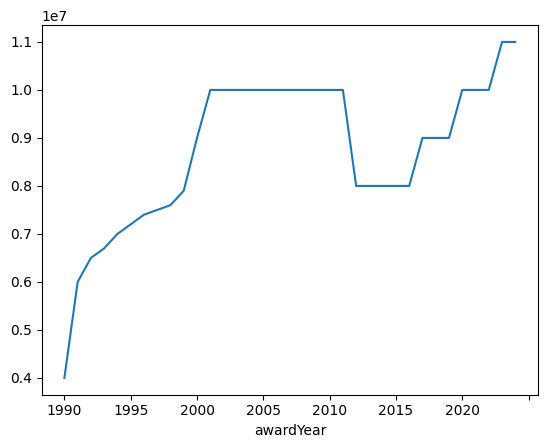

In [110]:
df
df.groupby("awardYear")["prizeAmount"].mean().plot.line()
#Price has gradually increased in general , but stagnated from 2000 to 2010, and went down in 2010-2011

7. Now plot the amount *adjusted for inflation* (there is a separate column for this).

What do you notice?

<Axes: xlabel='awardYear'>

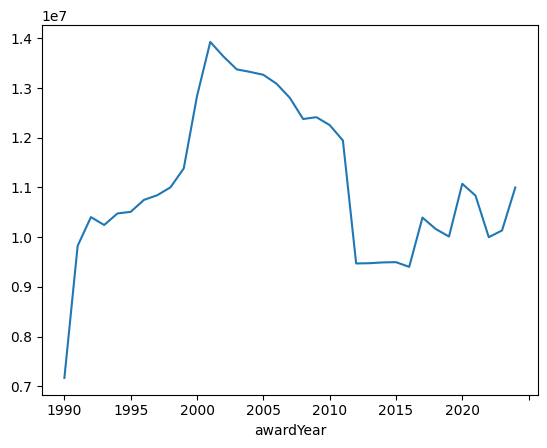

In [112]:
df
df.groupby("awardYear")["prizeAmountAdjusted"].mean().plot.line()
#Price has gradually increased in general , but stagnated from 2000 to 2010, and went down in 2010-2011
#Actually went down between 2000 to 2010. Increased steadily after 2011 but not as much as the inflation. 

### *BONUS*

Another research question:

#### Which Nobel prizes are typically awarded to *multiple* people?

8. First, using the `laureates` column, create a new column containing a count of how many people won a given prize in a given year (the items in `laureates` should be a list, count the items in the list and store the value as a new column).

In [156]:
print(df["laureates"])
df["laureates"][0]

#df.head()


0      [{'id': '275', 'knownName': {'en': 'Elias Jame...
1      [{'id': '704', 'knownName': {'en': 'Harry M. M...
2      [{'id': '667', 'knownName': {'en': 'Octavio Pa...
3      [{'id': '552', 'knownName': {'en': 'Mikhail Go...
4      [{'id': '138', 'knownName': {'en': 'Jerome I. ...
                             ...                        
205    [{'id': '1044', 'knownName': {'en': 'Daron Ace...
206    [{'id': '1042', 'knownName': {'en': 'Han Kang'...
207    [{'id': '1043', 'orgName': {'en': 'Nihon Hidan...
208    [{'id': '1037', 'knownName': {'en': 'John J. H...
209    [{'id': '1035', 'knownName': {'en': 'Victor Am...
Name: laureates, Length: 210, dtype: object


[{'id': '275',
  'knownName': {'en': 'Elias James Corey'},
  'fullName': {'en': 'Elias James Corey'},
  'portion': '1',
  'sortOrder': '1',
  'motivation': {'en': 'for his development of the theory and methodology of organic synthesis',
   'se': 'för hans utveckling av den organiska syntesens teori och metodik'},
  'links': {'rel': 'laureate',
   'href': 'https://api.nobelprize.org/2/laureate/275',
   'action': 'Get',
   'types': 'application/json'}}]

9. Each record contains more information in a nested format. Expand the `category` column to enhance your data with the English name of the prize category (e.g. peace, physics etc.).

10. Now calculate the average number of laureates per prize category.

Plot the results as a bar chart.

What do you conclude?

# Web scraping

Web scraping is needed when data is on the web but not accessible with a clean API.

In these instances, we can extract the data from the web page directly.

We can use `requests` to get the raw HTML of a web page, which we can then explore.

We're going to scrape data from a fictional bookstore: http://books.toscrape.com/

In [157]:
bookstore_response = requests.get("http://books.toscrape.com/")

bookstore_response.raise_for_status()

The returned content is now not JSON, but raw HTML in a string

In [158]:
bookstore_response.text

'<!DOCTYPE html>\n<!--[if lt IE 7]>      <html lang="en-us" class="no-js lt-ie9 lt-ie8 lt-ie7"> <![endif]-->\n<!--[if IE 7]>         <html lang="en-us" class="no-js lt-ie9 lt-ie8"> <![endif]-->\n<!--[if IE 8]>         <html lang="en-us" class="no-js lt-ie9"> <![endif]-->\n<!--[if gt IE 8]><!--> <html lang="en-us" class="no-js"> <!--<![endif]-->\n    <head>\n        <title>\n    All products | Books to Scrape - Sandbox\n</title>\n\n        <meta http-equiv="content-type" content="text/html; charset=UTF-8" />\n        <meta name="created" content="24th Jun 2016 09:29" />\n        <meta name="description" content="" />\n        <meta name="viewport" content="width=device-width" />\n        <meta name="robots" content="NOARCHIVE,NOCACHE" />\n\n        <!-- Le HTML5 shim, for IE6-8 support of HTML elements -->\n        <!--[if lt IE 9]>\n        <script src="//html5shim.googlecode.com/svn/trunk/html5.js"></script>\n        <![endif]-->\n\n        \n            <link rel="shortcut icon" href

To be able to extract components from this, we will use the `BeautifulSoup` library.

In [159]:
from bs4 import BeautifulSoup

We create a "beautiful soup" object from the raw HTML

In [160]:
soup = BeautifulSoup(bookstore_response.text, "html.parser")

In [161]:
type(soup)

bs4.BeautifulSoup

Looking at the object, it still looks like the HTML but we have additional methods available to us to explore it.

In [162]:
soup

<!DOCTYPE html>

<!--[if lt IE 7]>      <html lang="en-us" class="no-js lt-ie9 lt-ie8 lt-ie7"> <![endif]-->
<!--[if IE 7]>         <html lang="en-us" class="no-js lt-ie9 lt-ie8"> <![endif]-->
<!--[if IE 8]>         <html lang="en-us" class="no-js lt-ie9"> <![endif]-->
<!--[if gt IE 8]><!--> <html class="no-js" lang="en-us"> <!--<![endif]-->
<head>
<title>
    All products | Books to Scrape - Sandbox
</title>
<meta content="text/html; charset=utf-8" http-equiv="content-type"/>
<meta content="24th Jun 2016 09:29" name="created"/>
<meta content="" name="description"/>
<meta content="width=device-width" name="viewport"/>
<meta content="NOARCHIVE,NOCACHE" name="robots"/>
<!-- Le HTML5 shim, for IE6-8 support of HTML elements -->
<!--[if lt IE 9]>
        <script src="//html5shim.googlecode.com/svn/trunk/html5.js"></script>
        <![endif]-->
<link href="static/oscar/favicon.ico" rel="shortcut icon"/>
<link href="static/oscar/css/styles.css" rel="stylesheet" type="text/css"/>
<link href="s

What we're interested in is extracting specific HTML **elements**.

For this, we need to learn a bit of syntax, which are technically CSS selectors. CSS is a way to style a web page (more info and tutorials here: https://www.w3schools.com/css/).

The simplest form of a selector is using a tag type. That is, finding elements on a page that are all the same type, such as links.

In HTML, a link is an `<a>` tag, so we can find all links like this:

In [163]:
links = soup.select("a")

links

[<a href="index.html">Books to Scrape</a>,
 <a href="index.html">Home</a>,
 <a href="catalogue/category/books_1/index.html">
                             
                                 Books
                             
                         </a>,
 <a href="catalogue/category/books/travel_2/index.html">
                             
                                 Travel
                             
                         </a>,
 <a href="catalogue/category/books/mystery_3/index.html">
                             
                                 Mystery
                             
                         </a>,
 <a href="catalogue/category/books/historical-fiction_4/index.html">
                             
                                 Historical Fiction
                             
                         </a>,
 <a href="catalogue/category/books/sequential-art_5/index.html">
                             
                                 Sequential Art
            

In [164]:
type(links)

bs4.element.ResultSet

In [165]:
type(links[0])

bs4.element.Tag

These are all `Tag` objects which represent an HTML element.

These link tags all contain:

- text, which is what we see displayed on the page
- an "href" which is the url to visit when you click the link

We can extract both using `BeautifulSoup`:

In [166]:
[link.text for link in links]

['Books to Scrape',
 'Home',
 '\n                            \n                                Books\n                            \n                        ',
 '\n                            \n                                Travel\n                            \n                        ',
 '\n                            \n                                Mystery\n                            \n                        ',
 '\n                            \n                                Historical Fiction\n                            \n                        ',
 '\n                            \n                                Sequential Art\n                            \n                        ',
 '\n                            \n                                Classics\n                            \n                        ',
 '\n                            \n                                Philosophy\n                            \n                        ',
 '\n                        

In [167]:
[link["href"] for link in links]

['index.html',
 'index.html',
 'catalogue/category/books_1/index.html',
 'catalogue/category/books/travel_2/index.html',
 'catalogue/category/books/mystery_3/index.html',
 'catalogue/category/books/historical-fiction_4/index.html',
 'catalogue/category/books/sequential-art_5/index.html',
 'catalogue/category/books/classics_6/index.html',
 'catalogue/category/books/philosophy_7/index.html',
 'catalogue/category/books/romance_8/index.html',
 'catalogue/category/books/womens-fiction_9/index.html',
 'catalogue/category/books/fiction_10/index.html',
 'catalogue/category/books/childrens_11/index.html',
 'catalogue/category/books/religion_12/index.html',
 'catalogue/category/books/nonfiction_13/index.html',
 'catalogue/category/books/music_14/index.html',
 'catalogue/category/books/default_15/index.html',
 'catalogue/category/books/science-fiction_16/index.html',
 'catalogue/category/books/sports-and-games_17/index.html',
 'catalogue/category/books/add-a-comment_18/index.html',
 'catalogue/ca

You might find many elements of the same type, but with a different `class`.

A class is a way to tell CSS which elements should look the same.

For example, all buttons on the webpage have the same classes, including one called `"btn"`.

In CSS, to select all items of the same class, we can use `.` like this:

In [168]:
buttons = soup.select(".btn")
buttons

[<button class="btn btn-primary btn-block" data-loading-text="Adding..." type="submit">Add to basket</button>,
 <button class="btn btn-primary btn-block" data-loading-text="Adding..." type="submit">Add to basket</button>,
 <button class="btn btn-primary btn-block" data-loading-text="Adding..." type="submit">Add to basket</button>,
 <button class="btn btn-primary btn-block" data-loading-text="Adding..." type="submit">Add to basket</button>,
 <button class="btn btn-primary btn-block" data-loading-text="Adding..." type="submit">Add to basket</button>,
 <button class="btn btn-primary btn-block" data-loading-text="Adding..." type="submit">Add to basket</button>,
 <button class="btn btn-primary btn-block" data-loading-text="Adding..." type="submit">Add to basket</button>,
 <button class="btn btn-primary btn-block" data-loading-text="Adding..." type="submit">Add to basket</button>,
 <button class="btn btn-primary btn-block" data-loading-text="Adding..." type="submit">Add to basket</button>,
 

<h1 style="color: #fcd805">Exercise: web scraping</h1>

Your turn to scrape some data from the bookshop!

We're going to extract all the prices from the page and calculate the average book price.

1. Inspect the web page. What makes each book price element unique?

_Hint: right-click and click Inspect to view the HTML behind an element on the page._

In [193]:
price_amt = soup.select(".price_color")
#price_amt[0].text
#type(price_amt)
prices = pd.Series([float(item.text[2:]) for item in price_amt ])
prices
prices.mean()

np.float64(38.048500000000004)

2. Use `BeautifulSoup` to select all the elements that show a book's price.

3. Extract only the displayed text from these elements into a list.

You should end up with a list of strings.

4. Create a `pandas` `Series` from this list of strings by using `pd.Series`.

5. Using your `pandas` knowledge, clean up these strings so they are just numeric prices, and convert the `Series` to be a numeric type.

6. Now calculate the average price of books on the web page.

In [215]:
pages_link = soup.select("li.next a")
pages_link[0]["href"]
#[link["href"] for link in pages_link]

'catalogue/page-2.html'

In [229]:
for page in range(1,5):
    req_text = requests.get("https://books.toscrape.com/catalogue/page-"+str(page)+".html").text
    soup = BeautifulSoup(req_text, "html.parser")
    price_amt = soup.select(".price_color")
    print(price_amt)
    for item in price_amt:
        prices = pd.Series([float(item.text[2:])
    


#prices.mean()

[<p class="price_color">Â£51.77</p>, <p class="price_color">Â£53.74</p>, <p class="price_color">Â£50.10</p>, <p class="price_color">Â£47.82</p>, <p class="price_color">Â£54.23</p>, <p class="price_color">Â£22.65</p>, <p class="price_color">Â£33.34</p>, <p class="price_color">Â£17.93</p>, <p class="price_color">Â£22.60</p>, <p class="price_color">Â£52.15</p>, <p class="price_color">Â£13.99</p>, <p class="price_color">Â£20.66</p>, <p class="price_color">Â£17.46</p>, <p class="price_color">Â£52.29</p>, <p class="price_color">Â£35.02</p>, <p class="price_color">Â£57.25</p>, <p class="price_color">Â£23.88</p>, <p class="price_color">Â£37.59</p>, <p class="price_color">Â£51.33</p>, <p class="price_color">Â£45.17</p>]
[<p class="price_color">Â£12.84</p>, <p class="price_color">Â£37.32</p>, <p class="price_color">Â£30.52</p>, <p class="price_color">Â£25.27</p>, <p class="price_color">Â£34.53</p>, <p class="price_color">Â£54.64</p>, <p class="price_color">Â£22.50</p>, <p class="price_color">Â£5